다양한 기계학습 방법을 통해 online 뉴스 인기도 예측력를 극대화
 
최종 평가는 아래 test 데이터를 활용, 최종 예측 평가 지표는 MAE (Mean Absolute Error).

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from graphviz import Source
from IPython.display import Image
from sklearn.tree import export_graphviz

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

## for regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style("whitegrid")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
path = "onlinenews.csv"
data = pd.read_csv(path, engine='python')
print("- Data has {} rows and {} columns.".format(*data.shape))
print("- Column names: ", list(data.columns))

X = data.drop([' shares'], axis=1)
y = data[' shares']

- Data has 39644 rows and 60 columns.
- Column names:  [' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity', ' global_sentiment_polarity', ' global_rate_positive_words', ' global

데이터 6:2:2 Train valid test 구분

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2015010720)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=2015010720)

# X_valid = scaler.transform(X_valid)

최적 파라미터 조정 없이 학습 및 테스트 진행

In [6]:
clf_dt = DecisionTreeRegressor(criterion='squared_error', max_depth=None)
clf_dt.fit(X_train, y_train)
y_train_pred = clf_dt.predict(X_train)
y_valid_pred = clf_dt.predict(X_valid)
y_test_pred = clf_dt.predict(X_test)

In [7]:
# Show train & validation accuracies
print('- MSE (Train)      : {:.4}'.format(mean_squared_error(y_train, y_train_pred)))
print('- MSE (Validation) : {:.4}'.format(mean_squared_error(y_valid, y_valid_pred)))
print('- MSE (test) : {:.4}'.format(mean_squared_error(y_test, y_test_pred)))
print('- MAE (Train)      : {:.4}'.format(mean_absolute_error(y_train, y_train_pred)))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_valid, y_valid_pred))))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_test, y_test_pred))))

- MSE (Train)      : 0.0
- MSE (Validation) : 4.918e+08
- MSE (test) : 4.623e+08
- MAE (Train)      : 0.0
- MAE (Validation) : 4511
- MAE (Validation) : 4615


### 기본 모델 선정 + 이상치제거 및 PowerTransformer 조합

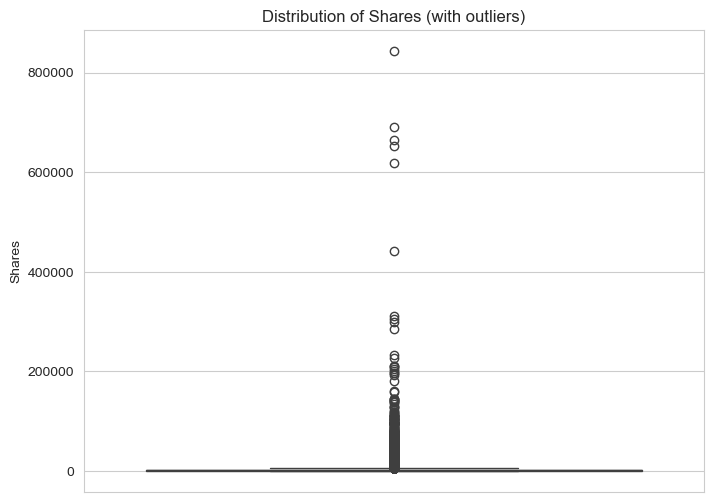

In [34]:
# 이상치 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(y=y)
plt.title('Distribution of Shares (with outliers)')
plt.ylabel('Shares')
plt.show()

LinearRegression:   0%|          | 0/10 [00:00<?, ?it/s]

raw          → MSE: 1.4615e+08, MAE: 3054.4219


LinearRegression:  20%|██        | 2/10 [00:00<00:02,  3.78it/s]

PT only      → MSE: 1.4546e+08, MAE: 3092.2512
remove 1%    → MSE: 1.4647e+08, MAE: 2644.2282


LinearRegression:  40%|████      | 4/10 [00:01<00:01,  3.90it/s]

remove 1% + PT → MSE: 1.4607e+08, MAE: 2639.3857
remove 0.5%  → MSE: 1.4604e+08, MAE: 2738.4920


LinearRegression:  60%|██████    | 6/10 [00:01<00:01,  4.00it/s]

remove 0.5% + PT → MSE: 1.4562e+08, MAE: 2732.8567
remove 0.25% → MSE: 1.4582e+08, MAE: 2809.7390


LinearRegression:  80%|████████  | 8/10 [00:01<00:00,  4.06it/s]

remove 0.25% + PT → MSE: 1.4534e+08, MAE: 2805.4521
IQR          → MSE: 1.5009e+08, MAE: 2361.7519


LinearRegression: 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


IQR + PT     → MSE: 1.4998e+08, MAE: 2358.6995


Ridge:   0%|          | 0/10 [00:00<?, ?it/s]

raw          → MSE: 1.4613e+08, MAE: 3052.4784


Ridge:  20%|██        | 2/10 [00:00<00:01,  4.29it/s]

PT only      → MSE: 1.4546e+08, MAE: 3092.2546
remove 1%    → MSE: 1.4647e+08, MAE: 2644.1570


Ridge:  40%|████      | 4/10 [00:00<00:01,  4.49it/s]

remove 1% + PT → MSE: 1.4607e+08, MAE: 2639.3902
remove 0.5%  → MSE: 1.4603e+08, MAE: 2737.5928


Ridge:  60%|██████    | 6/10 [00:01<00:00,  4.62it/s]

remove 0.5% + PT → MSE: 1.4562e+08, MAE: 2732.8579
remove 0.25% → MSE: 1.4581e+08, MAE: 2809.0260


Ridge:  80%|████████  | 8/10 [00:01<00:00,  4.62it/s]

remove 0.25% + PT → MSE: 1.4534e+08, MAE: 2805.4435
IQR          → MSE: 1.5009e+08, MAE: 2361.7377


Ridge: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


IQR + PT     → MSE: 1.4998e+08, MAE: 2358.7038


Lasso:   0%|          | 0/10 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e+12, tolerance: 3.516e+08
  model = cd_fast.enet_coordinate_descent(
Lasso:  10%|█         | 1/10 [00:02<00:18,  2.07s/it]

raw          → MSE: 1.4604e+08, MAE: 3044.4905


Lasso:  20%|██        | 2/10 [00:04<00:17,  2.18s/it]

PT only      → MSE: 1.4545e+08, MAE: 3091.3608


Lasso:  30%|███       | 3/10 [00:04<00:10,  1.48s/it]

remove 1%    → MSE: 1.4647e+08, MAE: 2644.1412


Lasso:  40%|████      | 4/10 [00:06<00:09,  1.57s/it]

remove 1% + PT → MSE: 1.4608e+08, MAE: 2639.8814


Lasso:  50%|█████     | 5/10 [00:07<00:06,  1.24s/it]

remove 0.5%  → MSE: 1.4601e+08, MAE: 2735.7608


Lasso:  60%|██████    | 6/10 [00:09<00:05,  1.44s/it]

remove 0.5% + PT → MSE: 1.4561e+08, MAE: 2732.9592


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.996e+11, tolerance: 7.160e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  70%|███████   | 7/10 [00:10<00:04,  1.47s/it]

remove 0.25% → MSE: 1.4578e+08, MAE: 2806.3399


Lasso:  80%|████████  | 8/10 [00:12<00:03,  1.64s/it]

remove 0.25% + PT → MSE: 1.4534e+08, MAE: 2804.9392


Lasso:  90%|█████████ | 9/10 [00:13<00:01,  1.26s/it]

IQR          → MSE: 1.5011e+08, MAE: 2363.7266


Lasso: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


IQR + PT     → MSE: 1.4999e+08, MAE: 2359.6866


KNeighbors:  10%|█         | 1/10 [00:00<00:03,  2.85it/s]

raw          → MSE: 1.5835e+08, MAE: 3230.4389


KNeighbors:  30%|███       | 3/10 [00:00<00:01,  3.59it/s]

PT only      → MSE: 1.5628e+08, MAE: 3145.0006
remove 1%    → MSE: 1.4965e+08, MAE: 2838.1015


KNeighbors:  50%|█████     | 5/10 [00:01<00:01,  3.88it/s]

remove 1% + PT → MSE: 1.4713e+08, MAE: 2731.2119
remove 0.5%  → MSE: 1.5064e+08, MAE: 2963.5664


KNeighbors:  70%|███████   | 7/10 [00:02<00:00,  3.96it/s]

remove 0.5% + PT → MSE: 1.4777e+08, MAE: 2823.5035
remove 0.25% → MSE: 1.5218e+08, MAE: 3065.8848


KNeighbors:  90%|█████████ | 9/10 [00:02<00:00,  3.98it/s]

remove 0.25% + PT → MSE: 1.4817e+08, MAE: 2919.9444
IQR          → MSE: 1.5050e+08, MAE: 2450.1682


KNeighbors: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


IQR + PT     → MSE: 1.5012e+08, MAE: 2393.1101


DecisionTree:  10%|█         | 1/10 [00:01<00:09,  1.07s/it]

raw          → MSE: 4.9251e+08, MAE: 4694.8740


DecisionTree:  20%|██        | 2/10 [00:02<00:10,  1.26s/it]

PT only      → MSE: 4.9334e+08, MAE: 4531.0320


DecisionTree:  30%|███       | 3/10 [00:03<00:07,  1.10s/it]

remove 1%    → MSE: 1.6008e+08, MAE: 3379.8002


DecisionTree:  40%|████      | 4/10 [00:04<00:06,  1.15s/it]

remove 1% + PT → MSE: 1.5943e+08, MAE: 3342.0733


DecisionTree:  50%|█████     | 5/10 [00:05<00:05,  1.08s/it]

remove 0.5%  → MSE: 1.6728e+08, MAE: 3624.7430


DecisionTree:  60%|██████    | 6/10 [00:06<00:04,  1.15s/it]

remove 0.5% + PT → MSE: 1.6724e+08, MAE: 3660.2761


DecisionTree:  70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

remove 0.25% → MSE: 1.8319e+08, MAE: 3782.9057


DecisionTree:  80%|████████  | 8/10 [00:09<00:02,  1.18s/it]

remove 0.25% + PT → MSE: 1.8031e+08, MAE: 3780.9465


DecisionTree:  90%|█████████ | 9/10 [00:09<00:01,  1.03s/it]

IQR          → MSE: 1.5095e+08, MAE: 2587.9155


DecisionTree: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


IQR + PT     → MSE: 1.5072e+08, MAE: 2589.8068


ExtraTrees:  10%|█         | 1/10 [00:07<01:09,  7.75s/it]

raw          → MSE: 1.5478e+08, MAE: 3359.4221


ExtraTrees:  20%|██        | 2/10 [00:16<01:04,  8.09s/it]

PT only      → MSE: 1.5485e+08, MAE: 3430.2516


ExtraTrees:  30%|███       | 3/10 [00:23<00:54,  7.72s/it]

remove 1%    → MSE: 1.4563e+08, MAE: 2754.8766


ExtraTrees:  40%|████      | 4/10 [00:31<00:46,  7.74s/it]

remove 1% + PT → MSE: 1.4508e+08, MAE: 2748.6603


ExtraTrees:  50%|█████     | 5/10 [00:38<00:37,  7.51s/it]

remove 0.5%  → MSE: 1.4532e+08, MAE: 2880.4177


ExtraTrees:  60%|██████    | 6/10 [00:45<00:30,  7.55s/it]

remove 0.5% + PT → MSE: 1.4511e+08, MAE: 2903.5330


ExtraTrees:  70%|███████   | 7/10 [00:52<00:22,  7.41s/it]

remove 0.25% → MSE: 1.4645e+08, MAE: 3002.6194


ExtraTrees:  80%|████████  | 8/10 [01:00<00:15,  7.55s/it]

remove 0.25% + PT → MSE: 1.4580e+08, MAE: 3007.5379


ExtraTrees:  90%|█████████ | 9/10 [01:07<00:07,  7.12s/it]

IQR          → MSE: 1.4958e+08, MAE: 2354.3449


ExtraTrees: 100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


IQR + PT     → MSE: 1.4954e+08, MAE: 2354.4284


RandomForest:  10%|█         | 1/10 [00:32<04:55, 32.78s/it]

raw          → MSE: 1.5678e+08, MAE: 3403.8136


RandomForest:  20%|██        | 2/10 [01:05<04:24, 33.03s/it]

PT only      → MSE: 1.5749e+08, MAE: 3430.1657


RandomForest:  30%|███       | 3/10 [01:34<03:35, 30.78s/it]

remove 1%    → MSE: 1.4612e+08, MAE: 2773.4278


RandomForest:  40%|████      | 4/10 [02:03<03:01, 30.31s/it]

remove 1% + PT → MSE: 1.4593e+08, MAE: 2771.5119


RandomForest:  50%|█████     | 5/10 [02:34<02:31, 30.32s/it]

remove 0.5%  → MSE: 1.4633e+08, MAE: 2929.3327


RandomForest:  60%|██████    | 6/10 [03:04<02:01, 30.41s/it]

remove 0.5% + PT → MSE: 1.4624e+08, MAE: 2929.3867


RandomForest:  70%|███████   | 7/10 [03:34<01:31, 30.37s/it]

remove 0.25% → MSE: 1.4682e+08, MAE: 3048.8923


RandomForest:  80%|████████  | 8/10 [04:05<01:01, 30.52s/it]

remove 0.25% + PT → MSE: 1.4697e+08, MAE: 3041.8611


RandomForest:  90%|█████████ | 9/10 [04:27<00:27, 27.67s/it]

IQR          → MSE: 1.4960e+08, MAE: 2353.1683


RandomForest: 100%|██████████| 10/10 [04:48<00:00, 28.90s/it]


IQR + PT     → MSE: 1.4961e+08, MAE: 2354.0967


AdaBoost:  10%|█         | 1/10 [00:02<00:26,  2.90s/it]

raw          → MSE: 6.9676e+08, MAE: 23075.5807


AdaBoost:  20%|██        | 2/10 [00:06<00:25,  3.15s/it]

PT only      → MSE: 6.6132e+08, MAE: 22512.6563


AdaBoost:  30%|███       | 3/10 [00:07<00:15,  2.22s/it]

remove 1%    → MSE: 1.4682e+08, MAE: 3588.2766


AdaBoost:  40%|████      | 4/10 [00:09<00:13,  2.23s/it]

remove 1% + PT → MSE: 1.4983e+08, MAE: 4350.0559


AdaBoost:  50%|█████     | 5/10 [00:11<00:09,  1.95s/it]

remove 0.5%  → MSE: 1.6098e+08, MAE: 5509.8385


AdaBoost:  60%|██████    | 6/10 [00:12<00:07,  1.80s/it]

remove 0.5% + PT → MSE: 1.5223e+08, MAE: 4120.0531


AdaBoost:  70%|███████   | 7/10 [00:13<00:04,  1.66s/it]

remove 0.25% → MSE: 1.5554e+08, MAE: 4541.0989


AdaBoost:  80%|████████  | 8/10 [00:15<00:03,  1.60s/it]

remove 0.25% + PT → MSE: 1.5573e+08, MAE: 4539.2467


AdaBoost:  90%|█████████ | 9/10 [00:16<00:01,  1.43s/it]

IQR          → MSE: 1.4904e+08, MAE: 2471.7109


AdaBoost: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


IQR + PT     → MSE: 1.4893e+08, MAE: 2499.0280


GradientBoosting:  10%|█         | 1/10 [00:13<02:01, 13.54s/it]

raw          → MSE: 1.4895e+08, MAE: 3025.2627


GradientBoosting:  20%|██        | 2/10 [00:27<01:48, 13.56s/it]

PT only      → MSE: 1.4761e+08, MAE: 3016.2191


GradientBoosting:  30%|███       | 3/10 [00:40<01:33, 13.34s/it]

remove 1%    → MSE: 1.4571e+08, MAE: 2612.8664


GradientBoosting:  40%|████      | 4/10 [00:53<01:20, 13.34s/it]

remove 1% + PT → MSE: 1.4582e+08, MAE: 2615.4335


GradientBoosting:  50%|█████     | 5/10 [01:06<01:06, 13.24s/it]

remove 0.5%  → MSE: 1.4545e+08, MAE: 2717.2984


GradientBoosting:  60%|██████    | 6/10 [01:19<00:52, 13.24s/it]

remove 0.5% + PT → MSE: 1.4547e+08, MAE: 2717.2434


GradientBoosting:  70%|███████   | 7/10 [01:32<00:39, 13.11s/it]

remove 0.25% → MSE: 1.4540e+08, MAE: 2788.9698


GradientBoosting:  80%|████████  | 8/10 [01:45<00:26, 13.16s/it]

remove 0.25% + PT → MSE: 1.4533e+08, MAE: 2787.3340


GradientBoosting:  90%|█████████ | 9/10 [01:57<00:12, 12.67s/it]

IQR          → MSE: 1.4986e+08, MAE: 2336.4388


GradientBoosting: 100%|██████████| 10/10 [02:09<00:00, 12.96s/it]


IQR + PT     → MSE: 1.4988e+08, MAE: 2336.7665


HistGradientBoosting:  10%|█         | 1/10 [00:00<00:01,  7.78it/s]

raw          → MSE: 1.4776e+08, MAE: 3079.2895


HistGradientBoosting:  20%|██        | 2/10 [00:00<00:02,  3.18it/s]

PT only      → MSE: 1.4776e+08, MAE: 3079.2895


HistGradientBoosting:  30%|███       | 3/10 [00:00<00:01,  3.60it/s]

remove 1%    → MSE: 1.4588e+08, MAE: 2608.0822


HistGradientBoosting:  40%|████      | 4/10 [00:01<00:02,  2.60it/s]

remove 1% + PT → MSE: 1.4588e+08, MAE: 2608.0764


HistGradientBoosting:  50%|█████     | 5/10 [00:01<00:01,  2.80it/s]

remove 0.5%  → MSE: 1.4526e+08, MAE: 2704.4029


HistGradientBoosting:  60%|██████    | 6/10 [00:02<00:01,  2.28it/s]

remove 0.5% + PT → MSE: 1.4526e+08, MAE: 2704.4029


HistGradientBoosting:  70%|███████   | 7/10 [00:02<00:01,  2.72it/s]

remove 0.25% → MSE: 1.4531e+08, MAE: 2788.8863


HistGradientBoosting:  80%|████████  | 8/10 [00:03<00:00,  2.33it/s]

remove 0.25% + PT → MSE: 1.4531e+08, MAE: 2788.8863


HistGradientBoosting:  90%|█████████ | 9/10 [00:03<00:00,  2.53it/s]

IQR          → MSE: 1.4988e+08, MAE: 2334.3028


HistGradientBoosting: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


IQR + PT     → MSE: 1.4988e+08, MAE: 2334.3028


XGBRegressor:  10%|█         | 1/10 [00:00<00:01,  5.08it/s]

raw          → MSE: 1.7299e+08, MAE: 3511.7261


XGBRegressor:  20%|██        | 2/10 [00:00<00:03,  2.60it/s]

PT only      → MSE: 1.7436e+08, MAE: 3563.2644


XGBRegressor:  30%|███       | 3/10 [00:00<00:02,  3.30it/s]

remove 1%    → MSE: 1.4655e+08, MAE: 2706.4673


XGBRegressor:  40%|████      | 4/10 [00:01<00:02,  2.61it/s]

remove 1% + PT → MSE: 1.4677e+08, MAE: 2707.5999


XGBRegressor:  50%|█████     | 5/10 [00:01<00:01,  3.13it/s]

remove 0.5%  → MSE: 1.4699e+08, MAE: 2864.8005


XGBRegressor:  70%|███████   | 7/10 [00:02<00:00,  3.10it/s]

remove 0.5% + PT → MSE: 1.4709e+08, MAE: 2871.4497
remove 0.25% → MSE: 1.4756e+08, MAE: 3007.7720


XGBRegressor:  90%|█████████ | 9/10 [00:03<00:00,  3.09it/s]

remove 0.25% + PT → MSE: 1.4808e+08, MAE: 2983.7424
IQR          → MSE: 1.4981e+08, MAE: 2350.9233


XGBRegressor: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


IQR + PT     → MSE: 1.4974e+08, MAE: 2349.5044


LGBMRegressor:  10%|█         | 1/10 [00:00<00:01,  5.36it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 59
[LightGBM] [Info] Start training from score 3448.969436
raw          → MSE: 1.5154e+08, MAE: 3179.9486


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  20%|██        | 2/10 [00:00<00:03,  2.47it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8450
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 59
[LightGBM] [Info] Start training from score 3448.969436
PT only      → MSE: 1.5182e+08, MAE: 3184.7756
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 59
[LightGBM] [Info] Start training from score 2692.134704


LGBMRegressor:  30%|███       | 3/10 [00:00<00:02,  3.26it/s]

remove 1%    → MSE: 1.4524e+08, MAE: 2596.8051


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  40%|████      | 4/10 [00:01<00:02,  2.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 59
[LightGBM] [Info] Start training from score 2692.134704
remove 1% + PT → MSE: 1.4566e+08, MAE: 2600.6502


LGBMRegressor:  50%|█████     | 5/10 [00:01<00:01,  2.98it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8438
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 59
[LightGBM] [Info] Start training from score 2892.703338
remove 0.5%  → MSE: 1.4538e+08, MAE: 2708.9592


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  60%|██████    | 6/10 [00:02<00:01,  2.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 59
[LightGBM] [Info] Start training from score 2892.703338
remove 0.5% + PT → MSE: 1.4544e+08, MAE: 2706.1365
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8443
[LightGBM] [Info] Number of data points in the train set: 23726, number of used features: 59
[LightGBM] [Info] Start training from score 3036.276111


LGBMRegressor:  70%|███████   | 7/10 [00:02<00:01,  2.95it/s]

remove 0.25% → MSE: 1.4376e+08, MAE: 2781.5232


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  80%|████████  | 8/10 [00:02<00:00,  2.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8448
[LightGBM] [Info] Number of data points in the train set: 23726, number of used features: 59
[LightGBM] [Info] Start training from score 3036.276111
remove 0.25% + PT → MSE: 1.4495e+08, MAE: 2776.1333
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8414
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 59
[LightGBM] [Info] Start training from score 1677.892864


LGBMRegressor:  90%|█████████ | 9/10 [00:03<00:00,  2.95it/s]

IQR          → MSE: 1.4977e+08, MAE: 2327.9582


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8421
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 59
[LightGBM] [Info] Start training from score 1677.892864
IQR + PT     → MSE: 1.4979e+08, MAE: 2328.9191


CatBoostRegressor:  10%|█         | 1/10 [00:01<00:14,  1.66s/it]

raw          → MSE: 1.5228e+08, MAE: 3119.7965


CatBoostRegressor:  20%|██        | 2/10 [00:03<00:14,  1.84s/it]

PT only      → MSE: 1.5057e+08, MAE: 3120.3538


CatBoostRegressor:  30%|███       | 3/10 [00:05<00:12,  1.74s/it]

remove 1%    → MSE: 1.4500e+08, MAE: 2583.6019


CatBoostRegressor:  40%|████      | 4/10 [00:07<00:10,  1.83s/it]

remove 1% + PT → MSE: 1.4505e+08, MAE: 2589.8988


CatBoostRegressor:  50%|█████     | 5/10 [00:08<00:08,  1.75s/it]

remove 0.5%  → MSE: 1.4544e+08, MAE: 2702.8994


CatBoostRegressor:  60%|██████    | 6/10 [00:10<00:07,  1.81s/it]

remove 0.5% + PT → MSE: 1.4518e+08, MAE: 2697.4932


CatBoostRegressor:  70%|███████   | 7/10 [00:12<00:05,  1.75s/it]

remove 0.25% → MSE: 1.4529e+08, MAE: 2788.8485


CatBoostRegressor:  80%|████████  | 8/10 [00:14<00:03,  1.83s/it]

remove 0.25% + PT → MSE: 1.4515e+08, MAE: 2793.2018


CatBoostRegressor:  90%|█████████ | 9/10 [00:16<00:01,  1.80s/it]

IQR          → MSE: 1.4975e+08, MAE: 2322.4467


CatBoostRegressor: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

IQR + PT     → MSE: 1.4978e+08, MAE: 2324.0495



/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_77476/1518795727.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


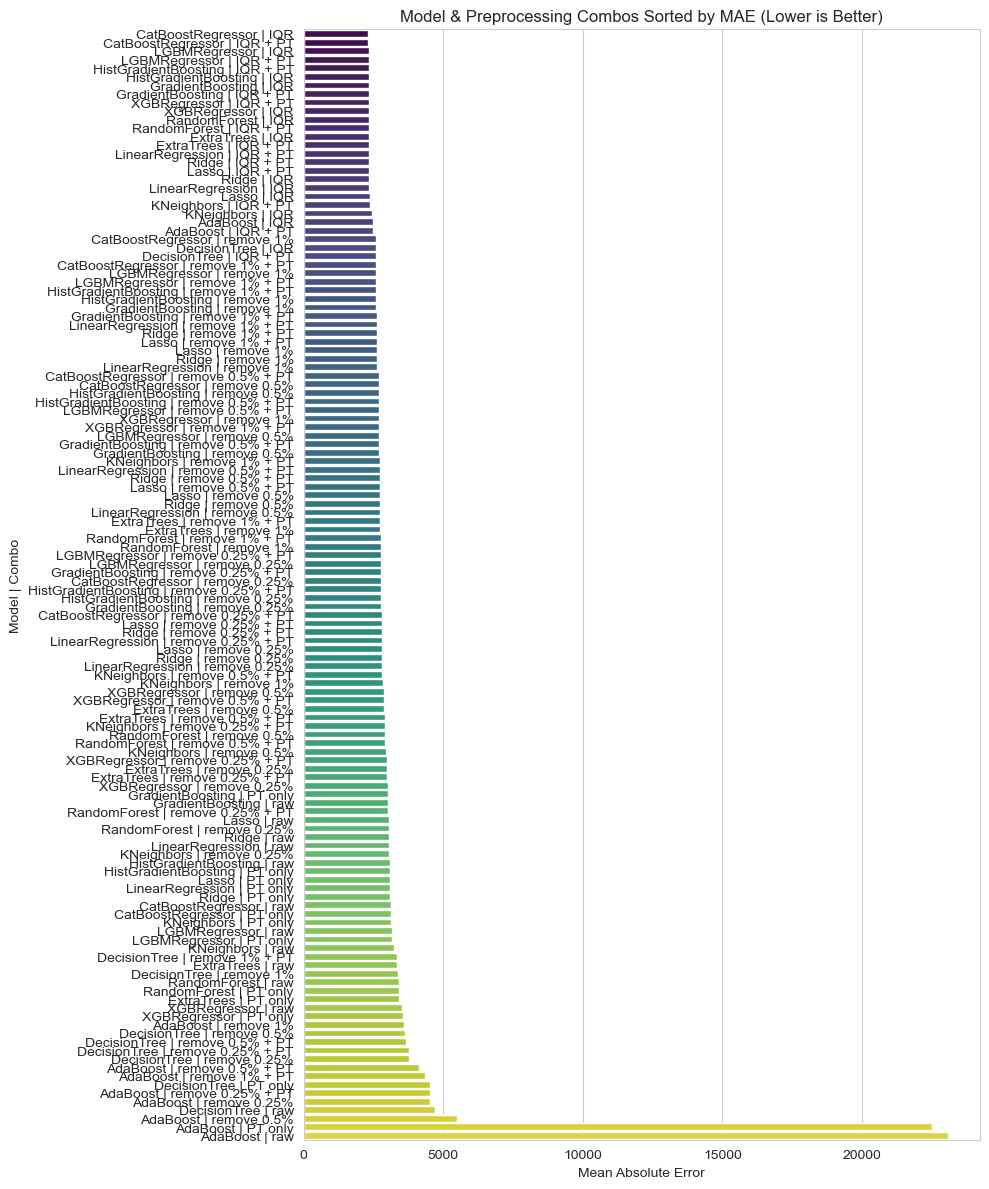

In [33]:
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 실행할 모델 정의
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=50, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42, verbosity=0),
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'CatBoostRegressor': CatBoostRegressor(random_state=42, verbose=False)
}

# 2) 전처리 조합 리스트
combos = [
    {'name': 'raw',             'remove_pct': None,    'use_iqr': False, 'use_pt': False},
    {'name': 'PT only',         'remove_pct': None,    'use_iqr': False, 'use_pt': True},
    {'name': 'remove 1%',       'remove_pct': 0.99,    'use_iqr': False, 'use_pt': False},
    {'name': 'remove 1% + PT',  'remove_pct': 0.99,    'use_iqr': False, 'use_pt': True},
    {'name': 'remove 0.5%',     'remove_pct': 0.995,   'use_iqr': False, 'use_pt': False},
    {'name': 'remove 0.5% + PT','remove_pct': 0.995,   'use_iqr': False, 'use_pt': True},
    {'name': 'remove 0.25%',    'remove_pct': 0.9975,  'use_iqr': False, 'use_pt': False},
    {'name': 'remove 0.25% + PT','remove_pct':0.9975,  'use_iqr': False, 'use_pt': True},
    {'name': 'IQR',             'remove_pct': None,    'use_iqr': True,  'use_pt': False},
    {'name': 'IQR + PT',        'remove_pct': None,    'use_iqr': True,  'use_pt': True}
]

# 3) 전처리·평가 함수
def preprocess_and_eval(model, X_tr, y_tr, X_te, y_te, remove_pct=None, use_iqr=False, use_pt=False):
    Xc, yc = X_tr.copy(), y_tr.copy()
    # 이상치 제거
    if use_iqr:
        Q1, Q3 = np.percentile(yc, [25, 75])
        IQR = Q3 - Q1
        mask = (yc >= Q1 - 1.5*IQR) & (yc <= Q3 + 1.5*IQR)
        Xc, yc = Xc[mask], yc[mask]
    elif remove_pct is not None:
        thresh = np.percentile(yc, remove_pct*100)
        mask = yc <= thresh
        Xc, yc = Xc[mask], yc[mask]
    # PowerTransformer
    if use_pt:
        pt = PowerTransformer(method='yeo-johnson')
        Xc = pt.fit_transform(Xc)
        Xte = pt.transform(X_te)
    else:
        Xte = X_te
    # 학습·예측
    clf = clone(model)
    clf.fit(Xc, yc)
    y_pred = clf.predict(Xte)
    return mean_squared_error(y_te, y_pred), mean_absolute_error(y_te, y_pred)

# 4) 일괄 실행 및 결과 수집
results = []
for model_name, model in models.items():
    for combo in tqdm(combos, desc=f'{model_name}'):
        mse, mae = preprocess_and_eval(
            model, X_train, y_train, X_test, y_test,
            remove_pct=combo['remove_pct'],
            use_iqr=combo['use_iqr'],
            use_pt=combo['use_pt']
        )
        # 개별 조합 결과 출력
        print(f"{combo['name']:12s} → MSE: {mse:.4e}, MAE: {mae:.4f}")
        results.append({
            'model': model_name,
            'combo': combo['name'],
            'MSE': mse,
            'MAE': mae
        })

# 5) DataFrame으로 변환, MAE 기준 정렬
df = pd.DataFrame(results)
df_sorted = df.sort_values(by='MAE', ascending=True)

# 6) 시각화
plt.figure(figsize=(10, 12))
sns.barplot(
    x='MAE',
    y=df_sorted['model'] + ' | ' + df_sorted['combo'],
    data=df_sorted,
    palette='viridis'
)
plt.title('Model & Preprocessing Combos Sorted by MAE (Lower is Better)')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Model | Combo')
plt.tight_layout()
plt.show()